In [45]:
# Import the needed libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



import os
import shutil
from PIL import Image
import pickle

import xgboost as xg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [7]:
# Read the CSV file into memory
pred = pd.read_csv("crop_yield_dataset.csv")


# Show data head
pred.head()

,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,Wheat,Peaty,5.50,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,2014-01-01,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,2014-01-01,Rice,Peaty,5.50,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
3,2014-01-01,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
4,2014-01-01,Soybean,Peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667


In [5]:
# Get brief info about the dataset
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36520 entries, 0 to 36519
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          36520 non-null  object 
 1   Crop_Type     36520 non-null  object 
 2   Soil_Type     36520 non-null  object 
 3   Soil_pH       36520 non-null  float64
 4   Temperature   36520 non-null  float64
 5   Humidity      36520 non-null  float64
 6   Wind_Speed    36520 non-null  float64
 7   N             36520 non-null  float64
 8   P             36520 non-null  float64
 9   K             36520 non-null  float64
 10  Crop_Yield    36520 non-null  float64
 11  Soil_Quality  36520 non-null  float64
dtypes: float64(9), object(3)
memory usage: 3.3+ MB


In [8]:
# Check the unique crop types in pred
pred["Crop_Type"].unique()

array(['Wheat', 'Corn', 'Rice', 'Barley', 'Soybean', 'Cotton',
       'Sugarcane', 'Tomato', 'Potato', 'Sunflower'], dtype=object)

In [9]:
# Create a filter list to drop crop types that are not needed
crop_list = ['Wheat', 'Sugarcane', 'Corn', 'Rice', 'Potato']

# Filter the DataFrame
pred = pred[pred["Crop_Type"].isin(crop_list)]
pred["Crop_Type"].unique()

array(['Wheat', 'Corn', 'Rice', 'Sugarcane', 'Potato'], dtype=object)

In [10]:
# Drop date column
pred.drop(columns = "Date", inplace = True)
pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18260 entries, 0 to 36518
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Crop_Type     18260 non-null  object 
 1   Soil_Type     18260 non-null  object 
 2   Soil_pH       18260 non-null  float64
 3   Temperature   18260 non-null  float64
 4   Humidity      18260 non-null  float64
 5   Wind_Speed    18260 non-null  float64
 6   N             18260 non-null  float64
 7   P             18260 non-null  float64
 8   K             18260 non-null  float64
 9   Crop_Yield    18260 non-null  float64
 10  Soil_Quality  18260 non-null  float64
dtypes: float64(9), object(2)
memory usage: 1.7+ MB


In [12]:
# Do descriptive statistic
pred.describe()

,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
count,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000
mean,6.602451,23.811898,74.259154,10.006339,71.960871,54.964458,40.769743,27.559699,38.888039
std,0.821474,8.906242,6.747989,3.001657,10.037026,8.970187,8.614989,26.492321,18.379978
min,5.500000,-2.390846,45.851089,-1.157606,55.000000,40.000000,27.000000,0.000000,13.916667
25%,6.250000,17.161352,69.758505,7.965251,65.000000,48.000000,35.000000,0.000000,22.833333
50%,6.500000,22.911403,77.088597,9.986377,71.500000,55.000000,40.500000,23.783572,39.083333
75%,6.750000,30.241495,80.000000,12.042389,78.000000,60.000000,45.000000,47.352618,53.083333
max,8.000000,54.148911,80.000000,21.115730,91.000000,72.000000,60.000000,136.711982,74.333333


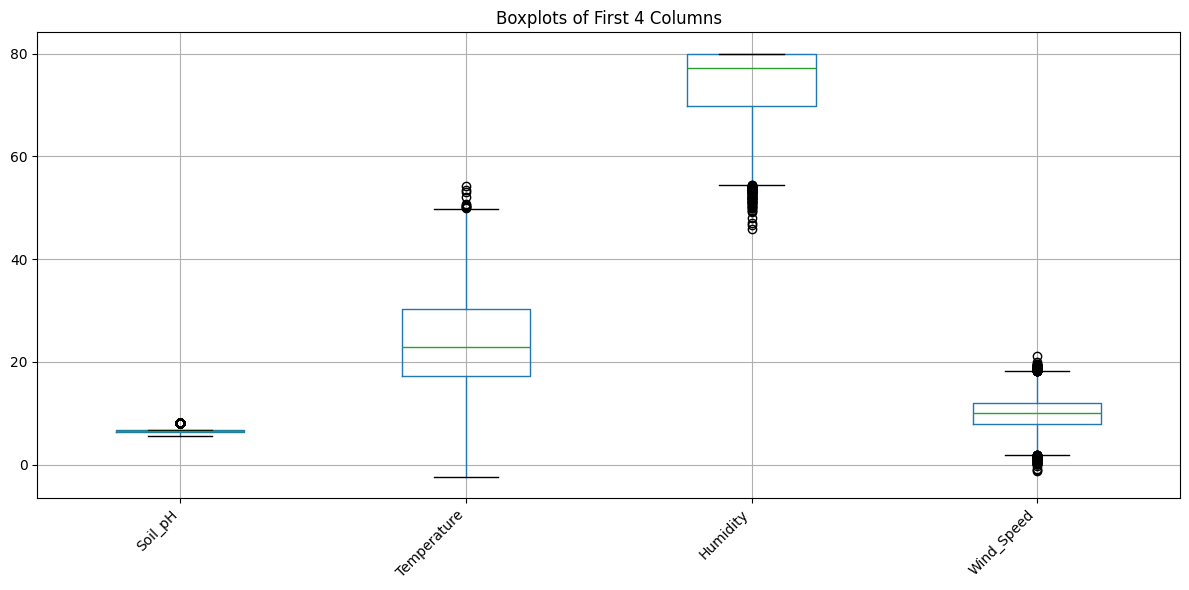

In [17]:
# Get numerical datatype features
pred_int = pred.select_dtypes("float64")

# Select the first 4 columns
cols_to_plot = list(pred_int.columns[:4])  # Convert Index to list

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplots
pred_int.boxplot(column=cols_to_plot, ax=ax)

# Customize the plot
plt.title("Boxplots of First 4 Columns")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

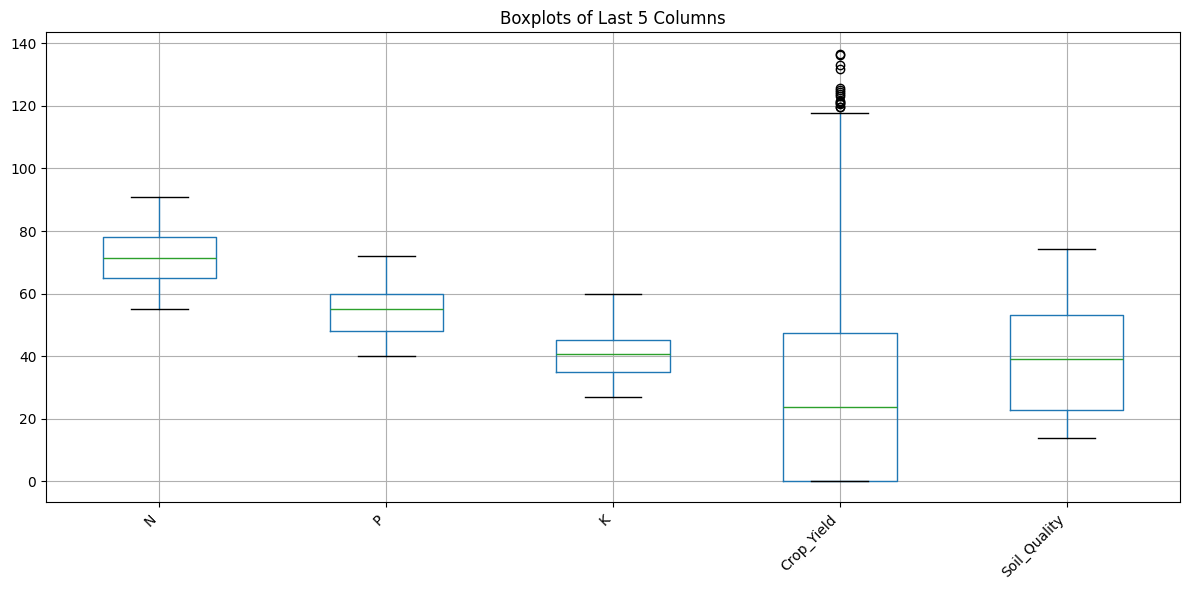

In [ ]:
# Select the last 5 columns
cols_to_plot = list(pred_int.columns[4:])  # Convert Index to list

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplots
pred_int.boxplot(column=cols_to_plot, ax=ax)

# Customize the plot
plt.title("Boxplots of Last 5 Columns")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
# Calculate correlation in dataset
correl = pred_int.corr()
correl

,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
Soil_pH,1.000000,0.001387,-0.002987,0.002396,0.297851,0.305524,0.295489,-0.016767,-0.325231
Temperature,0.001387,1.000000,-0.941938,0.006590,-0.006977,-0.007081,-0.006776,-0.229386,-0.006987
Humidity,-0.002987,-0.941938,1.000000,-0.009570,0.007047,0.007193,0.006990,0.456537,0.007999
Wind_Speed,0.002396,0.006590,-0.009570,1.000000,-0.002120,-0.002035,-0.002363,-0.010349,-0.008098
N,0.297851,-0.006977,0.007047,-0.002120,1.000000,0.999091,0.987174,0.153886,0.382743
P,0.305524,-0.007081,0.007193,-0.002035,0.999091,1.000000,0.986889,0.155678,0.383793
K,0.295489,-0.006776,0.006990,-0.002363,0.987174,0.986889,1.000000,0.151152,0.380222
Crop_Yield,-0.016767,-0.229386,0.456537,-0.010349,0.153886,0.155678,0.151152,1.000000,0.190965
Soil_Quality,-0.325231,-0.006987,0.007999,-0.008098,0.382743,0.383793,0.380222,0.190965,1.000000


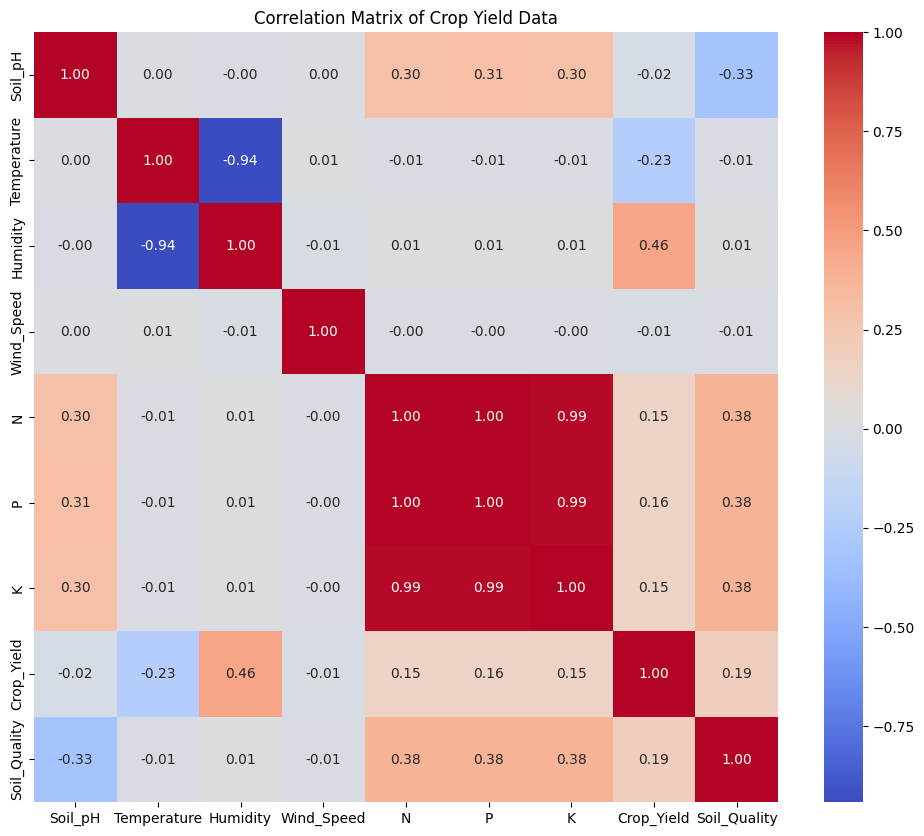

In [ ]:
# Calculate the correlation
correl = pred_int.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correl, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Crop Yield Data')
plt.show()

In [19]:
# Get the available 
pred.columns

Index(['Crop_Type', 'Soil_Type', 'Soil_pH', 'Temperature', 'Humidity',
       'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality'],
      dtype='object')

In [20]:
# Drop conflicting columns
pred = pred.drop(columns = ["P", "K", "Soil_Quality"])
pred.columns

Index(['Crop_Type', 'Soil_Type', 'Soil_pH', 'Temperature', 'Humidity',
       'Wind_Speed', 'N', 'Crop_Yield'],
      dtype='object')

In [21]:
# Encode categorical features
pred['Crop_Type'] = pred['Crop_Type'].astype('category').cat.codes
pred['Soil_Type'] = pred['Soil_Type'].astype('category').cat.codes
pred.head()

,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,Crop_Yield
0,4,2,5.5,9.440599,80.000000,10.956707,60.5,0.000000
1,0,1,6.5,20.052576,79.947424,8.591577,84.0,104.871310
2,2,2,5.5,12.143099,80.000000,7.227751,71.5,0.000000
6,3,3,8.0,13.533004,80.000000,9.910484,84.5,0.000000
8,1,2,5.5,18.895963,80.000000,6.696707,60.5,54.259727


In [22]:
# Model splitting

X = pred.drop(columns = "Crop_Yield")
y = pred["Crop_Yield"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Training and evaluating a Baseline Model
baseline_pred = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, baseline_pred)
mse_baseline = mean_squared_error(y_train, baseline_pred)
baseline_r2 = r2_score(y_train, baseline_pred)
print(f"Baseline Mean Absolute Error' is: {mae_baseline:.2f} metric tons per hectare")
print(f"Baseline Mean Squared Error: {mse_baseline:.2f} (metric tons per hectare)²")
print(f"Baseline Coefficient of Determination (R2): {baseline_r2:.2f}")

Baseline Mean Absolute Error' is: 22.76 metric tons per hectare
Baseline Mean Squared Error: 704.31 (metric tons per hectare)²
Baseline Coefficient of Determination (R2): 0.00


In [24]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [25]:
# Make predictions on the test set
linear_y_pred = linear_model.predict(X_test)

# Evaluate the model
linear_mae = mean_absolute_error(y_test, linear_y_pred)
linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_r2 = r2_score(y_test, linear_y_pred)
print(f"Linear Regression Mean Absolute Error: {linear_mae:.2f} metric tons per hectare")
print(f"Linear Regression Mean Squared Error: {linear_mse:.2f} (metric tons per hectare)²")
print(f"Linear Regression Coefficient of Determination (R2): {(linear_r2*100):.2f}")

Linear Regression Mean Absolute Error: 12.98 metric tons per hectare
Linear Regression Mean Squared Error: 276.11 (metric tons per hectare)²
Linear Regression Coefficient of Determination (R2): 60.08


In [26]:
# XGB Regressor
xg_model = xg.XGBRegressor(random_state = 42)
xg_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [27]:
# Make predictions on the test set
xg_y_pred = xg_model.predict(X_test)

# Evaluate the model
xg_mae = mean_absolute_error(y_test, xg_y_pred)
xg_mse = mean_squared_error(y_test, xg_y_pred)
xg_r2 = r2_score(y_test, xg_y_pred)
print(f"XGBoost Mean Absolute Error: {xg_mae:.2f} metric tons per hectare")
print(f"XGBoost Mean Squared Error: {xg_mse:.2f} (metric tons per hectare)²")
print(f"XGBoost Coefficient of Determination (R2): {(xg_r2*100):.2f}")

XGBoost Mean Absolute Error: 2.53 metric tons per hectare
XGBoost Mean Squared Error: 16.82 (metric tons per hectare)²
XGBoost Coefficient of Determination (R2): 97.57


In [28]:
# Decision Tree Regressor
decision_model = DecisionTreeRegressor(random_state = 42)
decision_model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [29]:
# Make predictions on the test set
decision_y_pred = decision_model.predict(X_test)

# Evaluate the model
decision_mae = mean_absolute_error(y_test, decision_y_pred)
decision_mse = mean_squared_error(y_test, decision_y_pred)
decision_r2 = r2_score(y_test, decision_y_pred)
print(f"Decision Tree Regressor Mean Absolute Error: {decision_mae:.2f} metric tons per hectare")
print(f"Decision Tree Mean Squared Error: {decision_mse:.2f} (metric tons per hectare)²")
print(f"Decision Tree Coefficient of Determination (R2): {(decision_r2*100):.2f}")

Decision Tree Regressor Mean Absolute Error: 3.22 metric tons per hectare
Decision Tree Mean Squared Error: 30.95 (metric tons per hectare)²
Decision Tree Coefficient of Determination (R2): 95.52


In [30]:
# Random Forest Regressor
random_model = RandomForestRegressor(random_state = 42)
random_model = random_model.fit(X_train, y_train)
random_model

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
# Make predictions on the test set
random_y_pred = random_model.predict(X_test)

# Evaluate the model
random_mae = mean_absolute_error(y_test, random_y_pred)
random_mse = mean_squared_error(y_test, random_y_pred)
random_r2 = r2_score(y_test, random_y_pred)
print(f"Random Forest Regressor Mean Absolute Error: {random_mae:.2f} metric tons per hectare")
print(f"Random Forest Mean Squared Error: {random_mse:.2f} (metric tons per hectare)²")
print(f"Random Forest Coefficient of Determination (R2): {random_r2:.2f}")

Random Forest Regressor Mean Absolute Error: 2.43 metric tons per hectare
Random Forest Mean Squared Error: 17.39 (metric tons per hectare)²
Random Forest Coefficient of Determination (R2): 0.97


In [32]:
# Support Vector Regressor
svr_model = SVR()
svr_model.fit(X_train, y_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [33]:
# Make predictions on the test set
svr_y_pred = svr_model.predict(X_test)

# Evaluate the model
svr_mae = mean_absolute_error(y_test, svr_y_pred)
svr_mse = mean_squared_error(y_test, svr_y_pred)
svr_r2 = r2_score(y_test, svr_y_pred)
print(f"Support Vector Regressor Mean Absolute Error: {svr_mae:.2f} metric tons per hectare")
print(f"Support Vector Regressor Mean Squared Error: {svr_mse:.2f} (metric tons per hectare)²")
print(f"Support Vector Regressor Coefficient of Determination (R2): {(svr_r2*100):.2f}")

Support Vector Regressor Mean Absolute Error: 15.35 metric tons per hectare
Support Vector Regressor Mean Squared Error: 386.57 (metric tons per hectare)²
Support Vector Regressor Coefficient of Determination (R2): 44.10


In [34]:
# KNeighbors Regressor
knr_model = KNeighborsRegressor()
knr_model.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [35]:
# Make predictions on the test set
knr_y_pred = knr_model.predict(X_test)

# Evaluate the model
knr_mae = mean_absolute_error(y_test, knr_y_pred)
knr_mse = mean_squared_error(y_test, svr_y_pred)
knr_r2 = r2_score(y_test, svr_y_pred)
print(f"KNeighbors Regressor Mean Absolute Error: {knr_mae:.2f} metric tons per hectare")
print(f"KNeighbors Regressor Mean Squared Error: {knr_mse:.2f} (metric tons per hectare)²")
print(f"KNeighbors Regressor Coefficient of Determination (R2): {(knr_r2*100):.2f}")

KNeighbors Regressor Mean Absolute Error: 2.69 metric tons per hectare
KNeighbors Regressor Mean Squared Error: 386.57 (metric tons per hectare)²
KNeighbors Regressor Coefficient of Determination (R2): 44.10


In [36]:
metrics = {
    'Baseline':   {'MAE': mae_baseline, 'MSE': mse_baseline, 'R2': baseline_r2},
    'XGBoost':    {'MAE': xg_mae,       'MSE': xg_mse,       'R2': xg_r2},
    'Linear Regression': {'MAE': linear_mae, 'MSE': linear_mse, 'R2': linear_r2},
    'Decision Tree': {'MAE': decision_mae, 'MSE': decision_mse, 'R2': decision_r2},
    'Random Forest': {'MAE': random_mae, 'MSE': random_mse, 'R2': random_r2},
    'Support Vector': {'MAE': svr_mae,   'MSE': svr_mse,      'R2': svr_r2},
    'KNeighbors':    {'MAE': knr_mae,    'MSE': knr_mse,      'R2': knr_r2}
}

# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics).T
metrics_df

,MAE,MSE,R2
Baseline,22.762262,704.308894,0.000000
XGBoost,2.526090,16.824471,0.975673
Linear Regression,12.982023,276.107245,0.600767
Decision Tree,3.218899,30.954095,0.955242
Random Forest,2.427245,17.392702,0.974851
Support Vector,15.350605,386.574573,0.441039
KNeighbors,2.693587,386.574573,0.441039


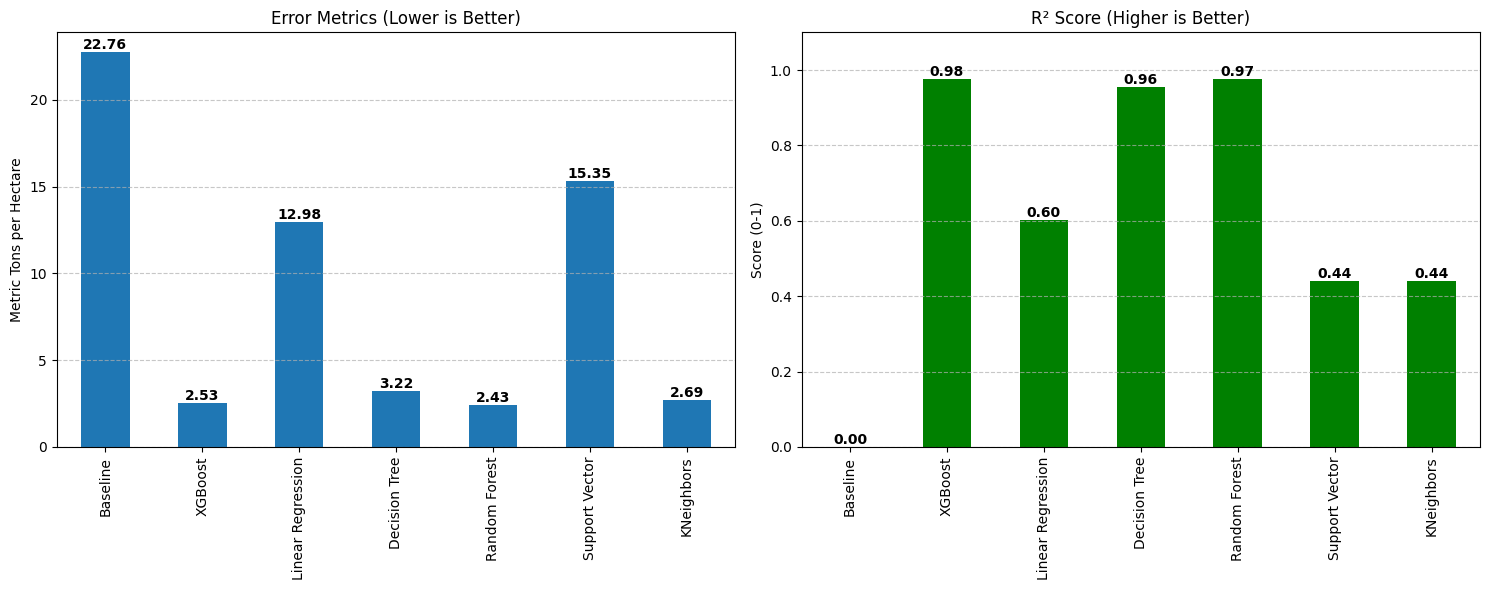

In [43]:
# Create a figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Error Metrics (MAE and MSE)
# Ideally, convert MSE to RMSE so units match MAE
metrics_df['MAE'].plot(kind='bar', ax=axes[0])
axes[0].set_title('Error Metrics (Lower is Better)')
axes[0].set_ylabel('Metric Tons per Hectare')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Plot 2: R2 Score
metrics_df['R2'].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('R² Score (Higher is Better)')
axes[1].set_ylabel('Score (0-1)')
axes[1].set_ylim(0, 1.1) # Set limit to see the bars clearly
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
plt.tight_layout()
plt.show()

In [46]:
# Define base model
random_model = RandomForestRegressor(random_state=42)

# Define hyperparameter space
param_dist = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, 1.0]
}

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=random_model,
    param_distributions=param_dist,
    n_iter=20,            # number of random combos to try
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [47]:
# Get best model parameters and MAE
print("Best Parameters:", random_search.best_params_)
print("Best MAE:", -random_search.best_score_)

Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': 30}
Best MAE: 2.363133154320314


In [49]:
# Feature importances
best_random_model = random_search.best_estimator_
feature_importances = pd.Series(best_random_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False)

Temperature    0.572817
Humidity       0.160949
Crop_Type      0.142663
Soil_Type      0.061299
N              0.052387
Soil_pH        0.005689
Wind_Speed     0.004196
dtype: float64

In [50]:
# Run prediction on X_test
random_y_pred = best_random_model.predict(X_test)

# Evaluate the model
random_mae = mean_absolute_error(y_test, random_y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, random_y_pred)):.2f}")
print(f"Coefficient of Determination (R² Score): {r2_score(y_test, random_y_pred):.2f}")
print(f"Random Forest Regressor Mean Absolute Error: {random_mae:.2f} metric tons per hectare")

Root Mean Squared Error: 4.01
Coefficient of Determination (R² Score): 0.98
Random Forest Regressor Mean Absolute Error: 2.34 metric tons per hectare


In [51]:
# Save the best random forest model
best_random_path = "crop_yield_best_random_model.pkl"
with open(best_random_path, 'wb') as f:
    pickle.dump(random_search.best_estimator_, f)
print(f"Best Model saved to {best_random_path}")

Best Model saved to crop_yield_best_random_model.pkl
